# CF 2.5: Advanced Geospatial Plotting

#### With the prior visualizations generated which showcase the differences between user groups and environmental factors like weather, the next step is to build an understanding of the geogrpahy of New York and the popularity of the citbike service within particular regions or routes - This will help allow us to answer questions pertaining to possible areas of expansion or re-investment.

### Script broken into 4 seperate sections:
1. Library & Data importing
2. Data checks
3. Data PreProcessing
4. Kepler.gl initialization & subsequent results

In [1]:
import pandas as pd
import os
from pyproj import CRS
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('nyc_bikes_dist.csv', index_col=0)

C:\Users\mojos\AppData\Local\Temp\ipykernel_30816\485023326.py:1: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nyc_bikes_dist.csv', index_col=0)


In [3]:
df.shape

(30689921, 21)

In [4]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_lng,member_casual,start_time,date,avgTemp,bike_rides_daily,trip_time,trip_dist_km,_merge,value
0,68FDAB9B6656A4DF,classic_bike,2022-01-01 05:11:08,2022-01-01 05:15:25,W 21 St & 6 Ave,6140.05,W 11 St & 6 Ave,5914.03,40.741740,-73.994156,...,-73.998004,member,2022-01-01 05:11:08,2022-01-01,11.6,20895,4.0,0.783088,both,1
1,91C955306D2CF8A6,electric_bike,2022-01-01 20:54:00,2022-01-01 21:06:39,Bedford Ave & Nassau Ave,5550.05,Sharon St & Olive St,5323.05,40.723117,-73.952123,...,-73.938560,member,2022-01-01 20:54:00,2022-01-01,11.6,20895,13.0,1.434057,both,1
2,B379B77AEB677F2A,electric_bike,2022-01-01 15:48:06,2022-01-01 16:44:21,Central Park W & W 91 St,7453.01,5 Ave & E 87 St,7323.09,40.788665,-73.966801,...,-73.959875,casual,2022-01-01 15:48:06,2022-01-01,11.6,20895,56.0,0.915302,both,1
3,1F1368CC1EEDA296,electric_bike,2022-01-01 02:32:52,2022-01-01 02:44:51,West End Ave & W 78 St,7340.07,W 44 St & 11 Ave,6756.05,40.783786,-73.981687,...,-73.996975,casual,2022-01-01 02:32:52,2022-01-01,11.6,20895,12.0,2.741188,both,1
4,9FE4ABC81014D80D,electric_bike,2022-01-01 17:43:17,2022-01-01 17:52:31,Lawrence St & Willoughby St,4596.09,Carroll St & 6 Ave,4019.06,40.692362,-73.986317,...,-73.978728,member,2022-01-01 17:43:17,2022-01-01,11.6,20895,9.0,2.128204,both,1


In [5]:
# generate a boolean val.
df['unfinished_ride'] = df['end_lat'].isna().astype(int)
df['unfinished_ride'].value_counts()

unfinished_ride
0    30652405
1       37516
Name: count, dtype: int64

In [6]:
#Since we want to make sure that long/lat are included in our df in order to be able to plot the route density in NYC we will be removing the small
#group of 'unfinished rides' where the long/lat of the end station are not given.

df2 = df[df['unfinished_ride']!=1]

In [7]:
df2.shape

(30652405, 22)

In [8]:
df2.isnull().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name       50
start_station_id         50
end_station_name      34257
end_station_id        34257
start_lat                 0
start_lng                 0
end_lat                   0
end_lng                   0
member_casual             0
start_time                0
date                      0
avgTemp                   0
bike_rides_daily          0
trip_time                 0
trip_dist_km              0
_merge                    0
value                     0
unfinished_ride           0
dtype: int64

#### There are still rows with missing data, though they represent >1% of the total df - We may not loose much by removing these from the analysis.

#### HOWEVER if we solely focus on coordinate values, we'll be able to retain the same qty of data. I'll have to see how these impact results as lat/long may have more pinpoint values which impact the apparant weight of some results

In [9]:
# Identify rows with any missing values and store them
rows_with_missing_values = df2[df2.isnull().any(axis=1)]

# Drop rows with any missing values from the original DataFrame
df_cleaned = df2.dropna()

In [10]:
# Due to issues with running the script / kepler I need to employ random sampling in order to be able to generate a dataset that doesn't overwhelm my PC.
np.random.seed(4)

dev = np.random.rand(len(df_cleaned)) <= 0.7

In [11]:
#Storing everything that is 'dev' (or under 0.7 random value) from the main DF - 70%

big = df_cleaned[dev]

In [12]:
#Storing everything that is not 'dev' (30% of DF)
small = df_cleaned[~dev]

In [13]:
len(df_cleaned)

30618148

In [14]:
len(big) + len(small)

30618148

In [15]:
df_group = small.groupby(['start_station_name', 'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng',])['value'].count().reset_index()

In [16]:
df_group['value'].sum()

np.int64(9184532)

In [17]:
df_group['value'].describe()

count    1.900121e+06
mean     4.833656e+00
std      2.205824e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.643000e+03
Name: value, dtype: float64

#### from the /describe() results above we can see that with a 'max' value of 12480 we do have some decent results from the aggregation. 'mean' is also not extremely close to '1' implying that specificity of the lat long coords didn't impact the aggregation results. (If the granularity was too small I may have been inundanted with trips only logged once.

#### If I notice on the geospatial visualizations that any trips don't appear to have sufficient weighting I'll reassess this script.

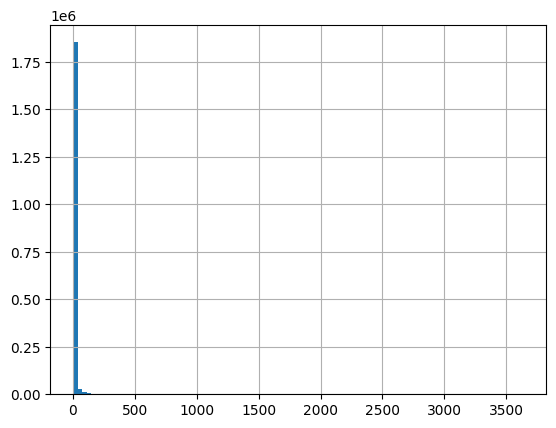

In [18]:
df_group['value'].hist(bins = 100)
plt.show()

[]

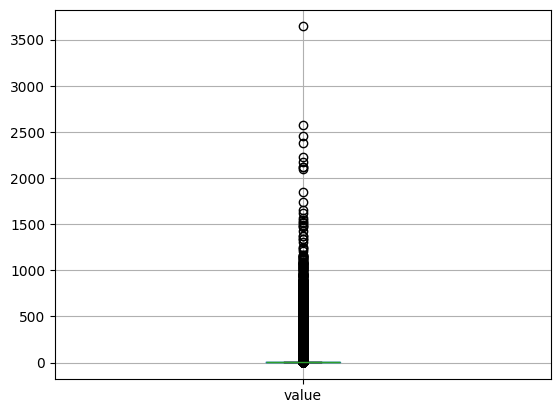

In [19]:
b_plot = df_group.boxplot(column = 'value') 
b_plot.plot()

In [20]:
df_group['value'].sort_index().value_counts()

value
1       1477217
2         92273
3         52063
4         35274
5         25520
         ...   
623           1
777           1
555           1
529           1
1544          1
Name: count, Length: 830, dtype: int64

In [21]:
df_group.rename(columns={'value':'Trip Count'},inplace=True)

In [22]:
df_group.to_csv('nyc_longlat_agg2.csv')

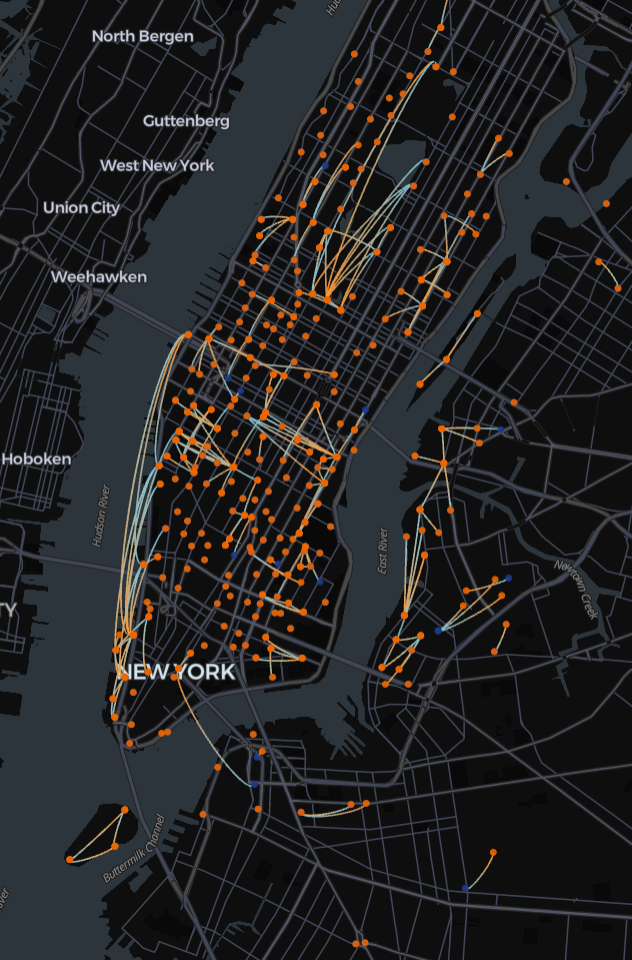

In [2]:
#image out put from KeplerGL browser
from IPython.display import Image, display


# Create an Image object and display it
image = Image('KeplerGL_screenshot.png')
display(image)

### Due to PC issues I've not been able to run KeplerGl within the script and have had to leave the link to the geospatial visualization here instead.

### LINK: https://kepler.gl/demo/map?mapUrl=https://dl.dropboxusercontent.com/scl/fi/nm3gnu3u1eyw2uzt72g90/keplergl_vmvny69.json?rlkey=e5o9msjaxzmv13lxwgvpylhwv&dl=0

### Based on the visualizations it's quite clear where the patterns are forming and what behaviours they hint at. The primary routes appear to be in toursit hotspots and are 'typically' simplistic routes which don't zigzag through the city (The arcs are 'as the crow flies' style lines, since we only know the end results rather than the specific routes) and are reflective of casual usage rather than end-to-end commutes. The main areas which high usage are scenic city routes which would be popular with city tourists that would be unlikely to come into the city with their own form of transit. The two most popular areas are the A) HUDSON RIVER GREENWAY (https://citibikenyc.com/explore/biking-hudson-river-greenway-temp) which overs scenic river routes through greenspaces and dedicated cycle paths which would be fantastic for casual users, and B) CENTRAL PARK, which gives NYC residents and tourists a break from the hustle and bustle. With over 42 Million Visits per year (https://en.wikipedia.org/wiki/Central_Park) and dedicated cycle routes it's no wonder that bikes are a popular choice (https://s3.amazonaws.com/assets.centralparknyc.org/media/documents/CPCWeb_Downloadablemaps_202407_Bike.pdf).
### Slightly less important, but still interesting observations are the qty of 'island' rentals that occur on both ROOSEVELT island and GOVERNERS island - Attractions which would probably be popular with both tourists and locals as they would be a ferry away and people may be less likely to bring their own bikes with them (but that's simple conjecture)
#### Lastly, There is a strong pocket of rides in the center of the city south of Central Park which represents high traffic tourist routes close to landmarks such as TIMES SQUARE, the EMPIRE STATE BUILDING, MADISON SQUARE GARDEN and the two most used stations - GRAND CENTRAL STATION and PENN STATION.